# MNIST Digit Classification with Naive Bayes Variants and KNN

## Introduction

In this project, we will explores various Naive Bayes models for classifying MNIST digits. We'll load and preprocess the data, then implement:

1. Gaussian Naive Bayes
2. None Naive Bayes
3. KNN Gaussian Naive Bayes

We will then do a comparaison between these Models before applying it to our case:
- Detecting handwritten notes during Tower Maintenance.

## Load and preprocess MNIST dataset

In this section, we will preprocesses the data by separating features and labels, and normalizes the pixel values for efficient machine learning model training to avoid that a pixel dominate the others. It prepares the dataset for use in a classification task.
- I applied ``MinMax Scaling`` as the dataset contains ``255`` as the maximum pixel and ``0`` as the minimum pixel => which imply **X_scaled** == X - 0 / (255 - 0) == **X / 255**

Finally, we plotted the "average" images per digit, this will help us showing typical digit patterns.

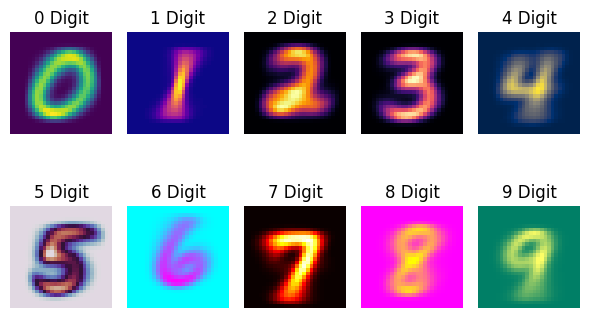

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load and preprocess MNIST dataset
train_data = pd.read_csv("inputs/MNIST_train.csv").to_numpy()
test_data = pd.read_csv("inputs/MNIST_test.csv").to_numpy()

X_train, y_train = train_data[:, 3:], train_data[:, 2]
X_test, y_test = test_data[:, 3:], test_data[:, 2]

# Normalize Dataset:
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

# Calculate and plot images for each digit
plt.figure(figsize=(6, 4))
colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'twilight', 'cool', 'hot', 'spring', 'summer']

def show_average_images(features, labels):
    for digit in range(10):
        observation_avg = features[labels == digit].mean(axis=0).reshape(28, 28)
        plt.subplot(2, 5, digit + 1)
        plt.imshow(observation_avg, cmap=colormaps[digit])
        plt.title(f"{digit} Digit")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_average_images(X_train_scaled, y_train)

## Applying Naive Bayes

**Accuracy achieved with The Gaussian Naive Bayes Model: **0.7746**.**

In this section, we build a custom Gaussian Naive Bayes classifier, which is trained and tested on a dataset to classify data points based on their features.
- It starts by fitting the model to the training data, learning the likelihoods and priors for each class.
- The model then makes predictions on the test data
- Additionally, I used the utlity function which I defined in the previous section to display average images based on the predicted labels. We can conclude that most images are detected.

The accuracy of Gaussian Naive Bayes Model is 0.7746


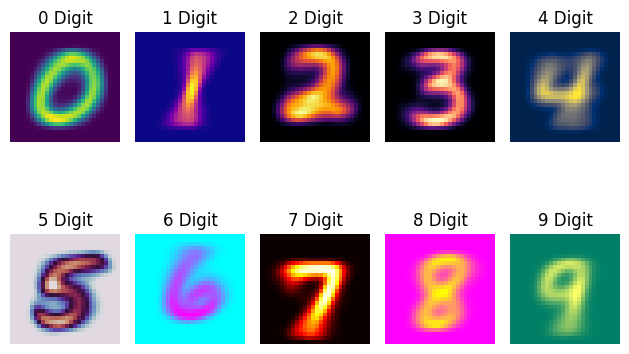

In [4]:
from scipy.stats import multivariate_normal as mvn

# Defining the Gaussion Naive Bayes Model:
class GaussNB():

  def fit(self, X, y, epsilon = 1e-3):
    self.likelihoods = dict()
    self.priors = dict()
    self.K = set(y.astype(int))

    for k in self.K:
      X_k = X[y==k]
      # Naive Assumption: Observations are linearly independant of each other
      self.likelihoods[k] = {"mean": X_k.mean(axis=0), "cov":X_k.var(axis=0)+epsilon}
      self.priors[k] = len(X_k) / len(X)

  def predict(self, X):

    N, D = X.shape
    P_hat = np.zeros((N, len(self.K)))

    for k, l in self.likelihoods.items():
      P_hat[:,k] = mvn.logpdf(X, l["mean"], l["cov"]) + np.log(self.priors[k])

    return P_hat.argmax(axis=1)
  
# Instanciate the Gaussion Naive Bayes Model:
gaussNB_classifier = GaussNB()

# Fit the Model with the trainning dataset
gaussNB_classifier.fit(X_train_scaled, y_train)

# Prediction
y_gNB_predicted = gaussNB_classifier.predict(X_test_scaled)

# Defining the accuracy
def accuracy(target, prediction):
  return np.mean(target == prediction)

# Calculate the accuracy:
accuracy_gNB = accuracy(y_test, y_gNB_predicted)
print(f"The accuracy of Gaussian Naive Bayes Model is {accuracy_gNB}")

# Displaying the average images:
show_average_images(X_test_scaled, y_gNB_predicted)

## Applying Non-Naive Gauss-Bayes Classifier

**Accuracy: **0.9108.****

In this section we implemented a custom Non-Naive Gaussian Bayes classifier that models the covariance matrix of the features, unlike the simpler Naive Bayes model.
- The model is trained on the dataset by calculating the mean and covariance matrix for each class.
- Then, it uses this information to predict the which digit was handwritten based on new data points.

Compared to the previous Model, we got an improvement in accuracy from the Gaussian Naive Bayes Model to the Gaussian Bayes Model with approximately **17.58%**.

The accuracy of Gaussian Bayes Model is 0.9108


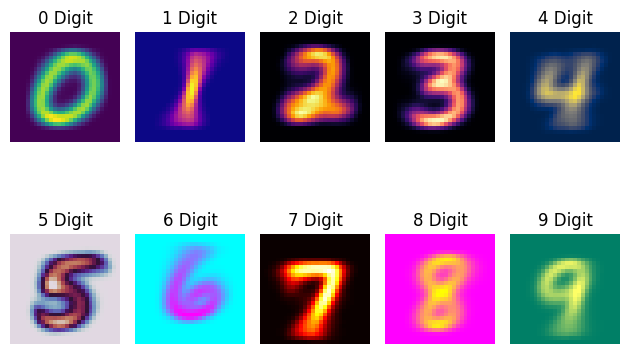

In [5]:
from scipy.stats import multivariate_normal as mvn

# Defining the Gaussion Naive Bayes Model:
class GaussBayes():
    def fit(self, X, y, epsilon=1e-3):
        self.likelihoods = dict()
        self.priors = dict()
        self.K = set(y.astype(int))

        for k in self.K:
            X_k = X[y==k,:]
            N_k, D = X_k.shape
            mu_k = X_k.mean(axis=0)\
            
            self.likelihoods[k] = {"mean": X_k.mean(axis=0), "cov":(1/(N_k-1))*np.matmul((X_k-mu_k).T, X_k-mu_k) + epsilon * np.identity(D)}

            self.priors[k] = len(X_k) / len(X)
        
    def predict(self, X):
        N, D = X.shape
        P_hat = np.zeros((N, len(self.K)))

        for k, l in self.likelihoods.items():
            P_hat[:,k] = mvn.logpdf(X, l["mean"], l["cov"]) + np.log(self.priors[k])

        return P_hat.argmax(axis=1)
    
# Instanciate the Gaussion Bayes Model:
gaussBayes_classifier = GaussBayes()

# Fit the Model with the trainning dataset
gaussBayes_classifier.fit(X_train_scaled, y_train, epsilon=1e-3)

# Prediction
y_gB_predicted = gaussBayes_classifier.predict(X_test_scaled)

# Accuracy of Gaussion Bayes Model
accuracy_gB = accuracy(y_test, y_gB_predicted)
print(f"The accuracy of Gaussian Bayes Model is {accuracy_gB}")

# Displaying the average images:
show_average_images(X_test_scaled, y_gB_predicted)

## Applying K-Nearest Neighbours Classifier

In this section, we will implement the K-Nearest Neighbors (KNN) classifier from scratch.
- The model is trained by storing the training data and then predicts the class of new data points by finding the K nearest neighbors based on Euclidean distance. 
- The prediction is made by weighting the influence of each neighbor inversely with their distance to the query point.
- The model is then evaluated on the test dataset, yielding a high accuracy of **0.9714** for **K = 4**.
- However, the execution time is notably long, taking about **45 minutes** to complete, which is typical for KNN due to its computational complexity.

In [6]:
class KNNClassifier():

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X, K, epsilon=1e-3):

        N = len(X)
        y_hat = np.zeros(N)

        for i in range(N):
            dist2 = np.sum((self.X - X[i]) ** 2, axis=1)
            # list of sorted nearest indexes:
            idxt = np.argsort(dist2)[:K]
            gamma_k = 1 / (np.sqrt(dist2[idxt]+epsilon))

            y_hat[i] = np.bincount(self.y[idxt], weights = gamma_k).argmax()

        return y_hat

# Instanciate the KNN Classifier
knn_classifier = KNNClassifier()

# Train the KNN Classifier
knn_classifier.fit(X_train_scaled, y_train)

In [5]:
# Predict the handwritten digits:
K = 4
y_knn_predicted = knn_classifier.predict(X_test_scaled, K)

execution times tooks: ~45min

In [ ]:
# Evaluate the accuracy of the KNN Model:
accuracy_knn = accuracy(y_test, y_knn_predicted)
print(accuracy_knn)

0.9714


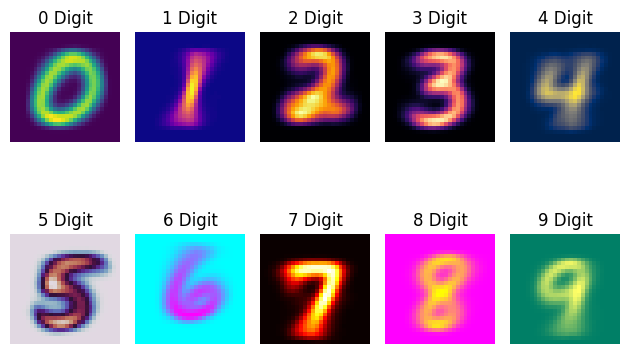

In [ ]:
# Displaying the average images:
show_average_images(X_test_scaled, y_knn_predicted)